In [1]:
import torch
import torchvision
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
# https://www.kaggle.com/ipythonx/van-gogh-paintings
data_path = Path('data/van-gogh-paintings/')

In [3]:
img_flist = list(data_path.glob('*/*.jpg'))
img_flist[0]

PosixPath('data/van-gogh-paintings/Arles/A Field of Yellow Flowers.jpg')

In [4]:
len(img_flist)

2025

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.eval()

In [6]:
def get_img_vec(img):
    feature_extractor = torch.nn.Sequential(*list(pretrained_model.children())[:-1])
    img = transforms(img).unsqueeze(dim=0)
    output = feature_extractor(img)
    output = torch.squeeze(output).detach().numpy()
    return output

In [7]:
N_max = 1000
N = min(N_max, len(img_flist))

vectors = []
for img_fpath in tqdm(img_flist[:N_max]):
    img = Image.open(img_fpath)
    vec = get_img_vec(img)
    vectors.append(vec)
    
df = pd.DataFrame(vectors)
df.insert(0,'fpath','')
df['fpath'] = img_flist[:N_max]

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/akim/.local/share/virtualenvs/cv_webinars-0oJbYyW7/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
df.head()

,fpath,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,data/van-gogh-paintings/Arles/A Field of Yello...,0.435855,1.108948,0.061785,0.687750,0.015281,0.091210,0.647453,2.962600,2.809080,...,0.300754,0.380919,0.099158,0.263510,0.343230,0.118847,0.251062,0.225102,0.322548,0.599363
1,data/van-gogh-paintings/Arles/A L Arlesienne M...,0.462135,2.148883,0.422899,0.988850,2.038613,1.620504,0.241982,0.798634,0.541568,...,0.629020,0.697394,1.121995,0.623752,0.983404,0.313664,1.775571,0.771539,0.251015,0.181173
2,data/van-gogh-paintings/Arles/A Lane in the Pu...,0.285017,0.688899,0.602998,0.035288,0.579540,0.536319,0.426817,0.458628,1.224975,...,0.287690,0.747594,0.083498,0.007698,0.034933,0.042100,0.589242,0.727671,0.019358,0.302608
3,data/van-gogh-paintings/Arles/A Lane near Arle...,0.488304,0.764262,0.140148,1.017228,1.631140,0.539348,0.601426,2.191087,1.598963,...,3.120024,1.237292,0.031101,0.466443,0.602053,0.209506,0.973683,0.799505,0.129912,0.130277
4,data/van-gogh-paintings/Arles/A Pair of Leathe...,0.045593,3.020575,1.248579,1.299021,1.252109,1.382175,1.693449,1.535090,0.438176,...,2.126607,1.631515,0.474456,0.671207,0.726185,0.320988,0.932413,0.169877,0.499503,1.717723


In [9]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(metric='cosine')
vectors = df.drop(columns='fpath').values
index = nn.fit(vectors)

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_similar(img, 
                n_neighbors=10):
    vector = get_img_vec(img)
    vector = [vector]
    neigh_dist, neigh_ind = index.kneighbors(vector, n_neighbors=n_neighbors, return_distance=True)
    neigh_dist, neigh_ind = neigh_dist[0], neigh_ind[0]
    neighbor_list = df.iloc[neigh_ind]['fpath'].values
    return neighbor_list, neigh_dist

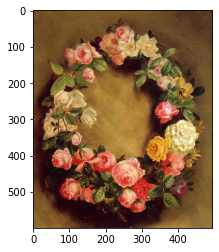

In [11]:
# https://www.wikiart.org/en/pierre-auguste-renoir/ball-at-the-moulin-de-la-galette-1876
import urllib.request

img_url = "https://uploads7.wikiart.org/images/pierre-auguste-renoir/crown-of-roses.jpg!Large.jpg"
fname = "crown-of-roses.jpg"
urllib.request.urlretrieve(img_url, fname)
sample_img = Image.open(fname)
plt.imshow(sample_img)

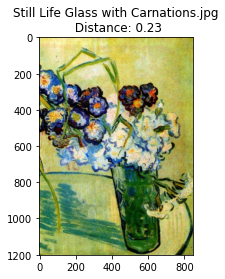

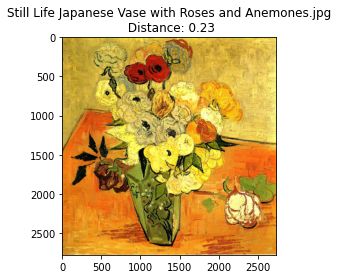

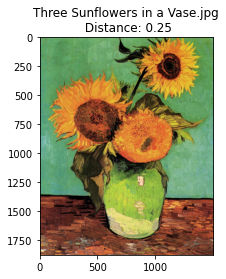

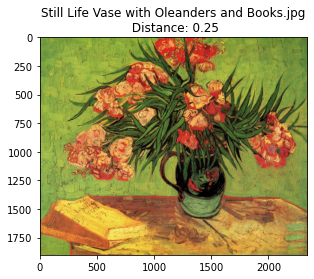

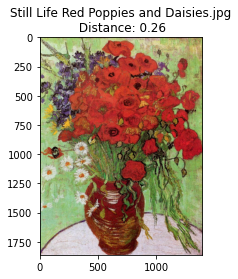

<Figure size 432x288 with 0 Axes>

In [12]:
neighbor_list, neigh_dist = get_similar(sample_img, n_neighbors=5)
for img_path, dist in zip(neighbor_list, neigh_dist):
    img = Image.open(img_path)
    plt.imshow(img)  
    plt.title(f'{img_path.name}\n Distance: {dist:.2f}')
    plt.figure()

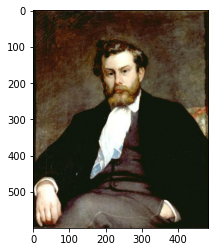

In [13]:
img_url = "https://uploads5.wikiart.org/images/pierre-auguste-renoir/the-painter-alfred-sisley-1868.jpg!Large.jpg"
fname = "the-painter-alfred-sisley"
urllib.request.urlretrieve(img_url, fname)
sample_img = Image.open(fname)
plt.imshow(sample_img)

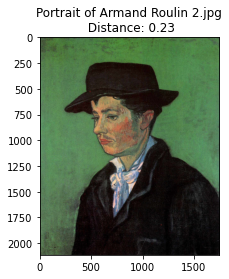

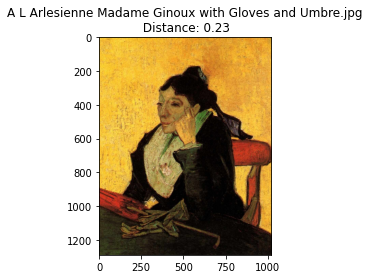

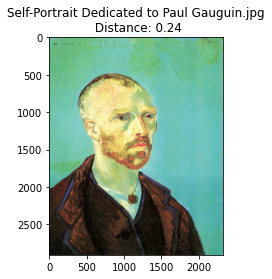

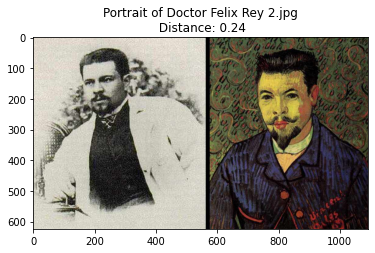

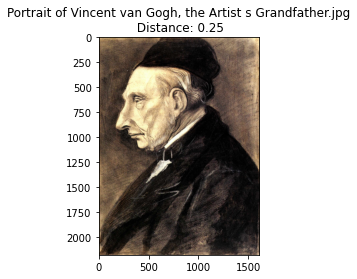

<Figure size 432x288 with 0 Axes>

In [14]:
neighbor_list, neigh_dist = get_similar(sample_img, n_neighbors=5)
for img_path, dist in zip(neighbor_list, neigh_dist):
    img = Image.open(img_path)
    plt.imshow(img)  
    plt.title(f'{img_path.name}\n Distance: {dist:.2f}')
    plt.figure()